# Задача 9
Целью данного эксперимента является сравнение производительности трёх  single source shortest path алгоритмов, в зависимости от процента изменившихся ребер и способа их изменения(только добавления/только удаления/добавление и удаление):

- Реализация алгоритма Беллмана-Форда основанная на операциях линейной алгебры
- Алгоритм Дейкстры
- Динамический алгоритм Дейкстры

In [1]:
import random
import time
import io
from itertools import zip_longest
from pathlib import Path
from typing import Hashable, Generator, Literal
import networkx as nx
import pygraphblas as gb

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

import sys
import os
sys.path.insert(0, '..')
from project.shortest_path import shortest_path_dijkstra, single_source_shortest_path_bellman_ford
from project.dynamic_shortest_path import DynamicSSSP

import sources directory


# Характеристики оборудования

In [2]:
get_ipython().system('echo "-- CPU --"')
get_ipython().system('lscpu | grep name')
get_ipython().system('echo "-- RAM --"')
get_ipython().system('free -h -t | grep Mem | cut -c1-23')
get_ipython().system('echo "-- OS --"')
get_ipython().system('uname --kernel-release')
get_ipython().system('echo "-- Python --"')
get_ipython().system('python --version')

-- CPU --
Model name:                      Intel(R) Core(TM) i5-10600KF CPU @ 4.10GHz
-- RAM --
Mem:            15Gi   
-- OS --
5.4.242-1-MANJARO
-- Python --
Python 3.10.10


# Генерация графов
В экспериментах используются 7 групп графов по числу вершин: <100, 1000, 5000, 10000, 25000, 50000, 100000 вершин.

В каждой категории находится по три графа c разным количеством вершин. Большее число графов не использовалось ввиду технических ограничений (долгое время генерации и весьма ограниченный объем оперативной памяти).

В категорию графов размера <100 вошли графы из области социальных сетей, остальные
генерировались средствами `networkx`. Использовался генератор `gaussian_random_partition_graph`, ввиду очевидной интерпретации его параметров, а также, как правило, генерации связных графов (позволяет избежать решение sssp на изолированом графе).

Итоговый генератор конфигурируется размером(описаны выше), а также количеством сообществ в графе(с количеством сообществ растет количество ребер в графе, и уменьшается связность сообществ между собой)

In [3]:
seed = 42
enable_logs = False
include_social_network_graphs = True
generate_graph_sizes = [1_000, 5_000, 10_000, 25_000, 50_000, 100_000]
generate_graph_community_count = [10, 50, 100]
modified_edges_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
results_file = Path("results.csv")
random.seed(seed)
if os.path.exists(results_file):
  os.remove(results_file)

In [4]:
def log(s):
    if enable_logs:
        print(s)

def generate_graphs():

    def generate_graph(n_vertices, n_clusters):
        mean_cluster_size = n_vertices / n_clusters
        shape_parameter = 3
        base_probability = 100 / n_vertices
        inside_connection_p = base_probability
        outside_connection_p = base_probability / n_clusters
        return nx.gaussian_random_partition_graph(
            n_vertices, mean_cluster_size, shape_parameter, inside_connection_p, outside_connection_p, directed=True, seed=seed
        )

    social_network_graphs = [
        nx.karate_club_graph().to_directed(),
        nx.davis_southern_women_graph().to_directed(),
        nx.les_miserables_graph().to_directed(),
    ]

    graphs = []
    if include_social_network_graphs:
        graphs.extend(social_network_graphs)
    
    for n_vertices in generate_graph_sizes:
        log(f"Generate graph with size: {n_vertices}")
        for community_count in generate_graph_community_count:
            graph = generate_graph(n_vertices, community_count)
            log(f"Generated graph with edges count: {graph.size()}")
            graphs.append(graph)
        log("")

    return graphs

# Постановка эксперимента
Время работы каждого алгоритма подсчитывалось на каждый
- Процент меняющихся ребер
- Вид изменений

Для всех алгоритмов, время работы замерялось на уже изменненом графе, переобразования графов также не учитывались, так как на практике, вероятнее всего, граф будет хранится в требуемом представлении

При смешанных обновлениях добавления и удаления рёбер происходили последовательно, так как ожидается, что порядок данных обновлений не влияет на время работы.

In [5]:
def save_result(
        algo,
        run_type,
        graph,
        modified_edges_ratio,
        time_sec,
):
    res_str = f"{algo},{run_type},{len(graph)},{modified_edges_ratio},{time_sec}"
    with open(results_file, "a") as f:
        f.write(res_str + "\n")
    log(f"Added result: {res_str}")

    
def _create_graph(nodes, edges, to_insert, to_delete):
    graph = nx.DiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges - to_delete)

    for u,v in graph.edges():
        graph[u][v]["weight"] = 1
    
    return graph
    

def run_graphblas_sssp(start, nodes, edges, to_insert, to_delete):
    graph = _create_graph(nodes, edges, to_insert, to_delete)
            
    graph_mat = gb.Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(graph).astype(float, copy=False))
    start_i = list(graph).index(start)
    t1 = time.perf_counter()
    single_source_shortest_path_bellman_ford(graph_mat, start_i)
    t2 = time.perf_counter()
    return t2 - t1


def run_dijkstra_sssp(start, nodes, edges, to_insert, to_delete):
    graph = _create_graph(nodes, edges, to_insert, to_delete)

    t1 = time.perf_counter()
    shortest_path_dijkstra(graph, start)
    t2 = time.perf_counter()
    return t2 - t1


def run_dynamic_sssp(start, nodes, edges, to_insert, to_delete):
    graph = nx.DiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges - to_insert)
    for u,v in graph.edges():
        graph[u][v]["weight"] = 1

    algo = DynamicSSSP(graph, start)
    for e in to_insert:
        algo.insert_edge(*e)
    for e in to_delete:
        algo.delete_edge(*e)

        
    t1 = time.perf_counter()
    algo.query_dists()
    t2 = time.perf_counter()
    return t2 - t1

def run_experiment(graphs, algo_name, run_algo):
    for graph in graphs:
        start = random.sample(list(graph.nodes), 1)[0]
        for modified_edges_ratio in modified_edges_ratios:
            edges_to_modify = random.sample(
                list(graph.edges), int(graph.number_of_nodes() * modified_edges_ratio)
            )
            
            # mixed
            edges_to_insert = edges_to_modify[:len(edges_to_modify) // 2]
            edges_to_delete = edges_to_modify[len(edges_to_modify) // 2:]
            
            t = run_algo(start, graph.nodes, graph.edges, edges_to_insert, edges_to_delete)
            save_result(algo_name, "Mixed", graph, modified_edges_ratio, t)

            # incremental 
            t = run_algo(start, graph.nodes, graph.edges, edges_to_modify, [])
            save_result(algo_name, "Incremental", graph, modified_edges_ratio, t)
            
            # decremental
            t = run_algo(start, graph.nodes, graph.edges, [], edges_to_modify)
            save_result(algo_name, "Decremental", graph, modified_edges_ratio, t)

In [6]:
graphs = generate_graphs()

In [7]:
run_experiment(graphs, "Dijkstra", run_dijkstra_sssp)
run_experiment(graphs, "Graphblas", run_graphblas_sssp)
run_experiment(graphs, "Dynamic", run_dynamic_sssp)

In [8]:
def show_comparsion(update_type):
    fig, axs = plt.subplots(ncols=len(modified_edges_ratios), nrows=1, figsize=(60, 10))
    data = pd.read_csv(results_file, names=["Algorithm", "update_type", "Number of vertices", "ratio", "Time, s"])
    data.loc[data['Number of vertices'] < 100, 'Number of vertices'] = "< 100"
    for i in range(len(modified_edges_ratios)):
        ratio = modified_edges_ratios[i]
        plot_data = data[(data.ratio == ratio) & (data.update_type == update_type)]
        plot = sns.barplot(plot_data, x="Number of vertices", y="Time, s", hue=f"Algorithm", ax=axs[i])
        plot.set_yscale("log")
        plot.set_title(f"Ratio: {ratio}")
    fig.tight_layout()

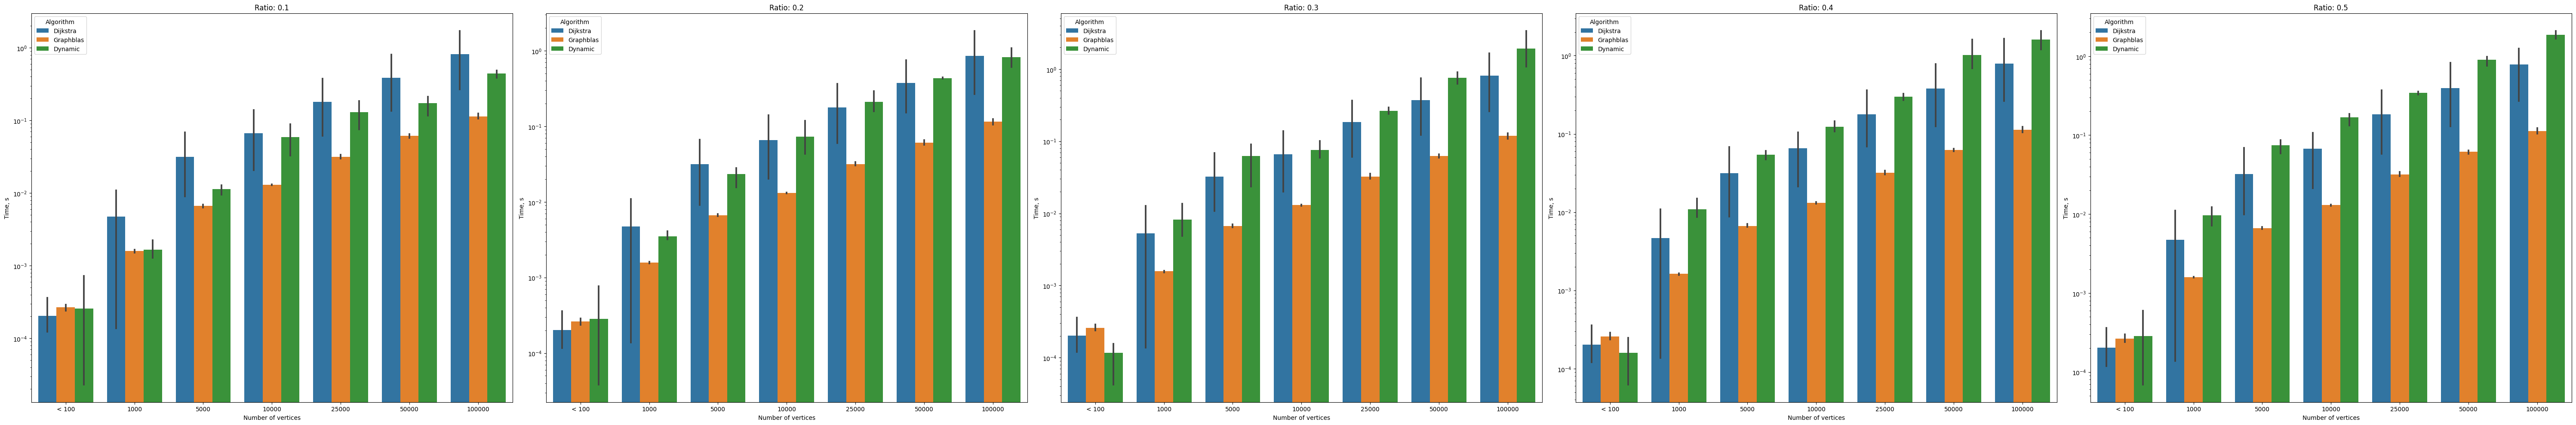

In [9]:
show_comparsion("Incremental")

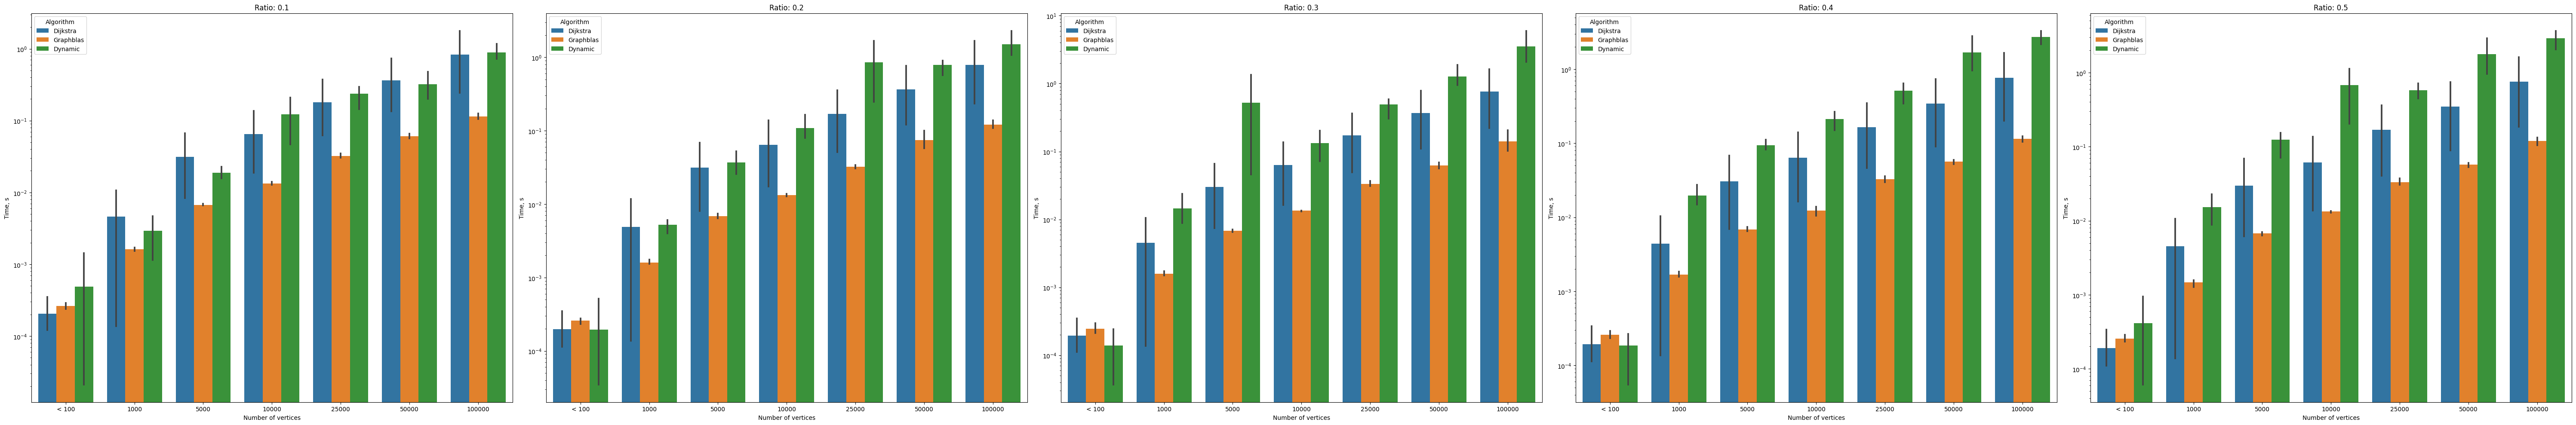

In [10]:
show_comparsion("Decremental")

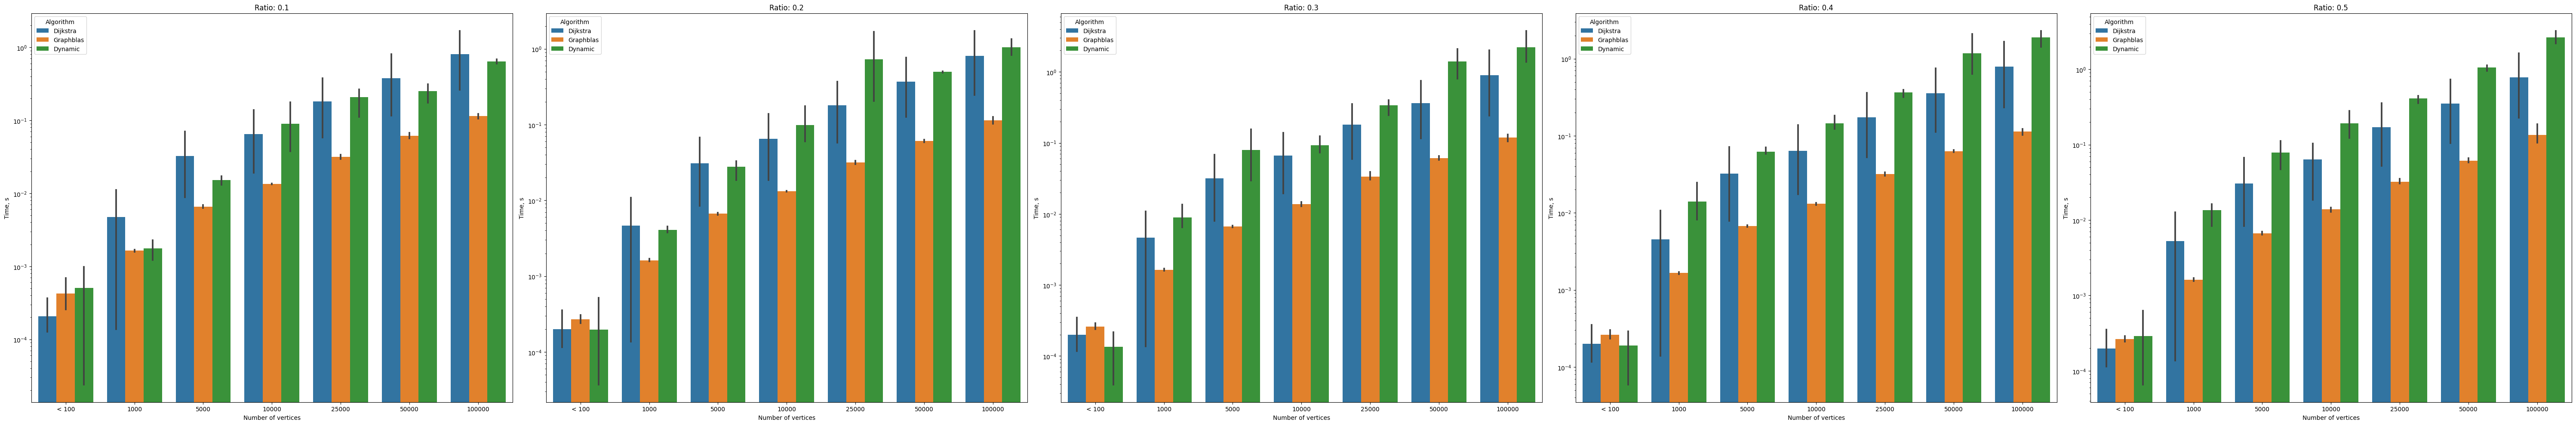

In [11]:
show_comparsion("Mixed")

# Выводы
1) При размере графа >1000 GraphBLAS реализация показывает себя кратно лучше других алгоритмов
2) Реализация статического алгоритма Дейкстры показывает себя лучше остальных алгоритмов при количестве вершин <1000 и сравнительно небольшом количестве ребер
3) Динамический алгоритм Дейкстры показывает себя лучше остальных алгоритмов на некоторых графах при количестве вершин <100, а также лучше статического алгоритма при инкрементальных обновлениях (ребра только добавляются) на графах <20000 вершин и количестве изменненых <20%.